# AI Travel Agent & Expense Planner
## Purpose: Trip planning for any city worldwide with Real-time data

In [7]:
# Install required packages
# !pip install langchain-groq langgraph langchain-community requests yfinance

from langchain_groq import ChatGroq
from langchain.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState, StateGraph, END, START
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
import requests
import json
from datetime import datetime, timedelta
from typing import Dict, List

In [8]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

In [9]:
# Initialize LLM
llm = ChatGroq(
    model_name="deepseek-r1-distill-llama-70b",
    temperature=0.3
)

# Initialize search tool
search = DuckDuckGoSearchRun()

## A) Search Attractions and Activities Tools

In [10]:
@tool
def search_attractions(destination_city: str, destination_country: str) -> str:
    """
    Search for top attractions in the destination city.
    
    Args:
        destination_city (str): The destination city name
        destination_country (str): The destination country name
    
    Returns:
        str: Information about top attractions
    """
    query = f"top attractions things to see {destination_city} {destination_country} 2025"
    try:
        result = search.invoke(query)
        return f"Top attractions in {destination_city}, {destination_country}:\n{result}"
    except Exception as e:
        return f"Error searching attractions: {str(e)}"

@tool
def search_restaurants(destination_city: str, destination_country: str) -> str:
    """
    Search for popular restaurants and local cuisine in the destination.
    
    Args:
        destination_city (str): The destination city name
        destination_country (str): The destination country name
    
    Returns:
        str: Information about restaurants and cuisine
    """
    query = f"best restaurants local food cuisine {destination_city} {destination_country} 2025"
    try:
        result = search.invoke(query)
        return f"Restaurant recommendations in {destination_city}, {destination_country}:\n{result}"
    except Exception as e:
        return f"Error searching restaurants: {str(e)}"

@tool
def search_activities(destination_city: str, destination_country: str) -> str:
    """
    Search for activities and experiences in the destination.
    
    Args:
        destination_city (str): The destination city name
        destination_country (str): The destination country name
    
    Returns:
        str: Information about activities and experiences
    """
    query = f"activities things to do experiences {destination_city} {destination_country} 2025"
    try:
        result = search.invoke(query)
        return f"Activities in {destination_city}, {destination_country}:\n{result}"
    except Exception as e:
        return f"Error searching activities: {str(e)}"

@tool
def search_transportation(starting_city: str, starting_country: str, destination_city: str, destination_country: str) -> str:
    """
    Search for transportation options between cities.
    
    Args:
        starting_city (str): The starting city name
        starting_country (str): The starting country name
        destination_city (str): The destination city name
        destination_country (str): The destination country name
    
    Returns:
        str: Transportation options and costs
    """
    query = f"flights buses trains transportation {starting_city} {starting_country} to {destination_city} {destination_country} cost 2025"
    try:
        result = search.invoke(query)
        return f"Transportation from {starting_city} to {destination_city}:\n{result}"
    except Exception as e:
        return f"Error searching transportation: {str(e)}"

## B) Weather Forecasting Tools

In [11]:
@tool
def get_current_weather(destination_city: str, destination_country: str) -> str:
    """
    Get current weather information for the destination.
    
    Args:
        destination_city (str): The destination city name
        destination_country (str): The destination country name
    
    Returns:
        str: Current weather information
    """
    query = f"current weather {destination_city} {destination_country} today temperature"
    try:
        result = search.invoke(query)
        return f"Current weather in {destination_city}, {destination_country}:\n{result}"
    except Exception as e:
        return f"Error getting current weather: {str(e)}"

@tool
def get_weather_forecast(destination_city: str, destination_country: str, days: int = 7) -> str:
    """
    Get weather forecast for the destination.
    
    Args:
        destination_city (str): The destination city name
        destination_country (str): The destination country name
        days (int): Number of days for forecast (default: 7)
    
    Returns:
        str: Weather forecast information
    """
    query = f"weather forecast {days} days {destination_city} {destination_country} temperature rain"
    try:
        result = search.invoke(query)
        return f"{days}-day weather forecast for {destination_city}, {destination_country}:\n{result}"
    except Exception as e:
        return f"Error getting weather forecast: {str(e)}"

## C) Hotel Cost Search Tools

In [12]:
@tool
def search_hotels(destination_city: str, destination_country: str, budget_range: str = "mid-range") -> str:
    """
    Search for hotels in the destination city.
    
    Args:
        destination_city (str): The destination city name
        destination_country (str): The destination country name
        budget_range (str): Budget range - "budget", "mid-range", or "luxury"
    
    Returns:
        str: Hotel information and prices
    """
    query = f"{budget_range} hotels {destination_city} {destination_country} price per night 2025"
    try:
        result = search.invoke(query)
        return f"{budget_range.title()} hotels in {destination_city}, {destination_country}:\n{result}"
    except Exception as e:
        return f"Error searching hotels: {str(e)}"

@tool
def estimate_hotel_cost(price_per_night: float, total_days: int) -> float:
    """
    Calculate total hotel cost based on price per night and number of days.
    
    Args:
        price_per_night (float): Price per night in local currency
        total_days (int): Total number of days
    
    Returns:
        float: Total hotel cost
    """
    try:
        total_cost = price_per_night * total_days
        return total_cost
    except Exception as e:
        return f"Error calculating hotel cost: {str(e)}"

@tool
def get_budget_range_info(budget_type: str, destination_city: str, destination_country: str) -> str:
    """
    Get information about different budget ranges for accommodation.
    
    Args:
        budget_type (str): "budget", "mid-range", or "luxury"
        destination_city (str): The destination city name
        destination_country (str): The destination country name
    
    Returns:
        str: Budget range information
    """
    query = f"{budget_type} accommodation cost range {destination_city} {destination_country} per night average"
    try:
        result = search.invoke(query)
        return f"{budget_type.title()} accommodation costs in {destination_city}, {destination_country}:\n{result}"
    except Exception as e:
        return f"Error getting budget range info: {str(e)}"

## D) Cost Calculation Tools

In [13]:
@tool
def add(a: float, b: float) -> float:
    """
    Add two numbers.
    
    Args:
        a (float): First number
        b (float): Second number
    
    Returns:
        float: Sum of a and b
    """
    return a + b

@tool
def multiply(a: float, b: float) -> float:
    """
    Multiply two numbers.
    
    Args:
        a (float): First number
        b (float): Second number
    
    Returns:
        float: Product of a and b
    """
    return a * b

@tool
def calculate_total_cost(hotel_cost: float, food_cost: float, transport_cost: float, activity_cost: float) -> float:
    """
    Calculate total trip cost by adding all expense categories.
    
    Args:
        hotel_cost (float): Total hotel/accommodation cost
        food_cost (float): Total food and dining cost
        transport_cost (float): Total transportation cost
        activity_cost (float): Total activities and attractions cost
    
    Returns:
        float: Total trip cost
    """
    total = hotel_cost + food_cost + transport_cost + activity_cost
    return total

@tool
def calculate_daily_budget(total_cost: float, total_days: int) -> float:
    """
    Calculate daily budget based on total cost and number of days.
    
    Args:
        total_cost (float): Total trip cost
        total_days (int): Total number of days
    
    Returns:
        float: Daily budget
    """
    if total_days == 0:
        return 0
    return total_cost / total_days

## E) Currency Conversion Tools

In [14]:
@tool
def get_exchange_rate(from_currency: str, to_currency: str) -> str:
    """
    Get current exchange rate between two currencies.
    
    Args:
        from_currency (str): Source currency code (e.g., 'USD')
        to_currency (str): Target currency code (e.g., 'EUR')
    
    Returns:
        str: Exchange rate information
    """
    query = f"exchange rate {from_currency} to {to_currency} current 2025"
    try:
        result = search.invoke(query)
        return f"Exchange rate {from_currency} to {to_currency}:\n{result}"
    except Exception as e:
        return f"Error getting exchange rate: {str(e)}"

@tool
def convert_currency(amount: float, exchange_rate: float, from_currency: str, to_currency: str) -> str:
    """
    Convert amount from one currency to another.
    
    Args:
        amount (float): Amount to convert
        exchange_rate (float): Exchange rate
        from_currency (str): Source currency code
        to_currency (str): Target currency code
    
    Returns:
        str: Converted amount with currency information
    """
    try:
        converted_amount = amount * exchange_rate
        return f"{amount} {from_currency} = {converted_amount:.2f} {to_currency} (Rate: {exchange_rate})"
    except Exception as e:
        return f"Error converting currency: {str(e)}"

## F) Itinerary Generation Tools

In [15]:
@tool
def create_day_plan(destination_city: str, destination_country: str, day_number: int, total_days: int) -> str:
    """
    Create a detailed plan for a specific day of the trip.
    
    Args:
        destination_city (str): The destination city name
        destination_country (str): The destination country name
        day_number (int): Which day of the trip (1, 2, 3, etc.)
        total_days (int): Total number of days in the trip
    
    Returns:
        str: Detailed day plan
    """
    query = f"day {day_number} itinerary {destination_city} {destination_country} what to do visit schedule"
    try:
        result = search.invoke(query)
        return f"Day {day_number} plan for {destination_city}, {destination_country}:\n{result}"
    except Exception as e:
        return f"Error creating day plan: {str(e)}"

@tool
def create_full_itinerary(destination_city: str, destination_country: str, total_days: int, interests: str = "general") -> str:
    """
    Create a complete itinerary for the entire trip.
    
    Args:
        destination_city (str): The destination city name
        destination_country (str): The destination country name
        total_days (int): Total number of days
        interests (str): Type of interests (culture, adventure, food, etc.)
    
    Returns:
        str: Complete itinerary
    """
    query = f"{total_days} day itinerary {destination_city} {destination_country} {interests} complete travel plan"
    try:
        result = search.invoke(query)
        return f"Complete {total_days}-day itinerary for {destination_city}, {destination_country} ({interests}):\n{result}"
    except Exception as e:
        return f"Error creating full itinerary: {str(e)}"

## Travel Planning System Setup

In [16]:
# Combine all tools
tools = [
    # Attraction and Activity tools
    search_attractions, search_restaurants, search_activities, search_transportation,
    # Weather tools
    get_current_weather, get_weather_forecast,
    # Hotel tools
    search_hotels, estimate_hotel_cost, get_budget_range_info,
    # Calculation tools
    add, multiply, calculate_total_cost, calculate_daily_budget,
    # Currency tools
    get_exchange_rate, convert_currency,
    # Itinerary tools
    create_day_plan, create_full_itinerary
]

# Bind tools to LLM
llm_with_tools = llm.bind_tools(tools)

# System prompt for travel agent
SYSTEM_PROMPT = SystemMessage(
    content="""You are an AI Travel Agent & Expense Planner. Your role is to help users plan comprehensive trips with real-time data.
    
    You have access to tools for:
    - Searching attractions, restaurants, activities, and transportation
    - Getting weather information and forecasts
    - Finding hotels and calculating accommodation costs
    - Performing cost calculations and budget planning
    - Converting currencies
    - Creating detailed itineraries
    
    Always provide comprehensive travel plans including:
    1. Weather information
    2. Top attractions and activities
    3. Hotel cost calculations
    4. Currency conversion
    5. Complete itinerary
    6. Total expense breakdown
    7. Trip summary
    
    Be helpful, detailed, and always try to provide accurate, up-to-date information.
    """
)

def travel_agent_function(state: MessagesState):
    """
    Main function for the travel agent that processes user queries.
    """
    user_messages = state["messages"]
    input_messages = [SYSTEM_PROMPT] + user_messages
    response = llm_with_tools.invoke(input_messages)
    return {"messages": [response]}

## Build the Travel Agent Graph

In [17]:
# Build the workflow graph
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("travel_agent", travel_agent_function)
workflow.add_node("tools", ToolNode(tools))

# Add edges
workflow.add_edge(START, "travel_agent")
workflow.add_conditional_edges(
    "travel_agent",
    tools_condition,
)
workflow.add_edge("tools", "travel_agent")

# Compile the graph
travel_agent_graph = workflow.compile()

print("Travel Agent Graph compiled successfully!")

Travel Agent Graph compiled successfully!


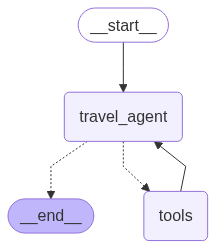

In [18]:
# Display the graph structure
from IPython.display import Image, display
try:
    display(Image(travel_agent_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    print("Graph visualization not available, but the system is ready to use!")

## Example Usage - Plan a Trip

In [19]:
# Example 1: Plan a trip from New York to Paris
messages = [HumanMessage(content="""
Plan a 5-day trip for me:
- From: New York City, USA
- To: Paris, France
- Starting Currency: USD
- Destination Currency: EUR
- Budget Range: Mid-range
- Interests: Culture, food, and sightseeing

Please provide a complete travel plan with weather forecast, attractions, restaurants, activities, hotel costs, transportation options, currency conversion, daily itinerary, and total expense calculation.
""")]

result = travel_agent_graph.invoke({"messages": messages})

In [20]:
# Display the travel plan
for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================


Plan a 5-day trip for me:
- From: New York City, USA
- To: Paris, France
- Starting Currency: USD
- Destination Currency: EUR
- Budget Range: Mid-range
- Interests: Culture, food, and sightseeing

Please provide a complete travel plan with weather forecast, attractions, restaurants, activities, hotel costs, transportation options, currency conversion, daily itinerary, and total expense calculation.

================================== Ai Message ==================================



To plan your 5-day trip from New York City, USA to Paris, France, I will follow these steps:

1. **Search for Transportation Options**: Find the best way to get from NYC to Paris, including costs.
2. **Get Weather Forecast**: Check the weather for the next 5 days in Paris.
3. **Search for Attractions**: Identify top cultural and sightseeing spots in Paris.
4. **Search for Restaurants**: Find mid-range restaurants serving local

## Example 2 - Different Destination

In [21]:
# Example 2: Plan a trip from London to Tokyo
messages = [HumanMessage(content="""
Create a comprehensive 7-day travel plan:
- From: London, UK
- To: Tokyo, Japan
- Starting Currency: GBP
- Destination Currency: JPY
- Budget Range: Luxury
- Interests: Technology, traditional culture, and cuisine

Include weather information, top attractions, hotel costs, food recommendations, activities, transportation details, currency conversion, complete itinerary, and expense breakdown with daily budget calculation.
""")]

result2 = travel_agent_graph.invoke({"messages": messages})

In [22]:
# Display the second travel plan
for message in result2['messages']:
    message.pretty_print()

================================ Human Message =================================


Create a comprehensive 7-day travel plan:
- From: London, UK
- To: Tokyo, Japan
- Starting Currency: GBP
- Destination Currency: JPY
- Budget Range: Luxury
- Interests: Technology, traditional culture, and cuisine

Include weather information, top attractions, hotel costs, food recommendations, activities, transportation details, currency conversion, complete itinerary, and expense breakdown with daily budget calculation.

================================== Ai Message ==================================
Tool Calls:
  search_transportation (n07trnfr7)
 Call ID: n07trnfr7
  Args:
    destination_city: Tokyo
    destination_country: Japan
    starting_city: London
    starting_country: UK
================================= Tool Message =================================
Name: search_transportation

Transportation from London to Tokyo:
Flights from Tokyo (HND), Japan to London (LHR), United Kingdom illustrated 

## Custom Trip Planning - Interactive

In [23]:
# Interactive trip planning function
def plan_custom_trip(starting_city, starting_country, destination_city, destination_country, 
                    starting_currency, destination_currency, days, budget_range="mid-range", 
                    interests="general"):
    """
    Plan a custom trip with user-specified parameters.
    
    Args:
        starting_city (str): The starting city name
        starting_country (str): The starting country name
        destination_city (str): The destination city name
        destination_country (str): The destination country name
        starting_currency (str): Starting currency code (e.g., 'USD')
        destination_currency (str): Destination currency code (e.g., 'EUR')
        days (int): Number of days for the trip
        budget_range (str): Budget range - "budget", "mid-range", or "luxury"
        interests (str): User interests and preferences
    
    Returns:
        dict: Complete travel plan result from the agent
    """
    query = f"""
    Plan a {days}-day comprehensive trip:
    - From: {starting_city}, {starting_country}
    - To: {destination_city}, {destination_country}
    - Starting Currency: {starting_currency}
    - Destination Currency: {destination_currency}
    - Budget Range: {budget_range}
    - Interests: {interests}
    
    Please provide:
    1. Current weather and forecast
    2. Top attractions and activities
    3. Restaurant recommendations
    4. Transportation options and costs
    5. Hotel recommendations and costs
    6. Currency conversion rates
    7. Day-by-day itinerary
    8. Total expense breakdown
    9. Daily budget calculation
    10. Trip summary
    """
    
    messages = [HumanMessage(content=query)]
    result = travel_agent_graph.invoke({"messages": messages})
    
    print(f"\n=== TRAVEL PLAN: {starting_city} to {destination_city} ({days} days) ===")
    for message in result['messages']:
        message.pretty_print()
    
    return result

# Example usage of custom function
print("Custom Trip Planning Function Created!")

Custom Trip Planning Function Created!


In [24]:
plan_custom_trip("Mumbai", "India", "Dubai", "UAE", "INR", "AED", 4, "luxury", "shopping and luxury")


=== TRAVEL PLAN: Mumbai to Dubai (4 days) ===
================================ Human Message =================================


    Plan a 4-day comprehensive trip:
    - From: Mumbai, India
    - To: Dubai, UAE
    - Starting Currency: INR
    - Destination Currency: AED
    - Budget Range: luxury
    - Interests: shopping and luxury
    
    Please provide:
    1. Current weather and forecast
    2. Top attractions and activities
    3. Restaurant recommendations
    4. Transportation options and costs
    5. Hotel recommendations and costs
    6. Currency conversion rates
    7. Day-by-day itinerary
    8. Total expense breakdown
    9. Daily budget calculation
    10. Trip summary
    
================================== Ai Message ==================================
Tool Calls:
  get_current_weather (ycqc87tzc)
 Call ID: ycqc87tzc
  Args:
    destination_city: Dubai
    destination_country: UAE
================================= Tool Message =================================
Name: 

{'messages': [HumanMessage(content='\n    Plan a 4-day comprehensive trip:\n    - From: Mumbai, India\n    - To: Dubai, UAE\n    - Starting Currency: INR\n    - Destination Currency: AED\n    - Budget Range: luxury\n    - Interests: shopping and luxury\n    \n    Please provide:\n    1. Current weather and forecast\n    2. Top attractions and activities\n    3. Restaurant recommendations\n    4. Transportation options and costs\n    5. Hotel recommendations and costs\n    6. Currency conversion rates\n    7. Day-by-day itinerary\n    8. Total expense breakdown\n    9. Daily budget calculation\n    10. Trip summary\n    ', additional_kwargs={}, response_metadata={}, id='037bfa94-77fa-4644-8e7f-f0c4369c2feb'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ycqc87tzc', 'function': {'arguments': '{"destination_city":"Dubai","destination_country":"UAE"}', 'name': 'get_current_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 709, 'p

In [ ]:
 plan_custom_trip("New York", "USA", "London", "UK", "USD", "GBP", 6, "mid-range", "history and museums")

In [ ]:
 plan_custom_trip("Tokyo", "Japan", "Seoul", "South Korea", "JPY", "KRW", 5, "budget", "food and culture")

In [ ]:
plan_custom_trip("Sydney", "Australia", "Bali", "Indonesia", "AUD", "IDR", 7, "luxury", "beaches and relaxation")

## Test Individual Tools

In [ ]:
# Test individual tools
print("Testing individual tools...")

# Test weather tool
weather_result = get_current_weather.invoke({"destination_city": "Paris", "destination_country": "France"})
print("Weather Tool Test:", weather_result[:100], "...")

# Test calculation tools
hotel_cost = estimate_hotel_cost.invoke({"price_per_night": 150.0, "total_days": 5})
print(f"Hotel Cost Calculation: {hotel_cost}")

# Test currency conversion setup
exchange_info = get_exchange_rate.invoke({"from_currency": "USD", "to_currency": "EUR"})
print("Exchange Rate Test:", exchange_info[:100], "...")

## Advanced Examples

In [ ]:
# Example 3: Budget trip planning
messages = [HumanMessage(content="""
Plan a budget-friendly 3-day trip:
- From: Mumbai, India
- To: Goa, India
- Starting Currency: INR
- Destination Currency: INR
- Budget Range: Budget
- Interests: Beaches, local food, and nightlife

Focus on cost-effective options and include detailed expense breakdown.
""")]

budget_result = travel_agent_graph.invoke({"messages": messages})

In [ ]:
# Display budget trip plan
print("=== BUDGET TRIP PLAN ===")
for message in budget_result['messages']:
    message.pretty_print()

In [ ]:
# Example 4: Business trip planning
messages = [HumanMessage(content="""
Plan a 4-day business trip:
- From: San Francisco, USA
- To: Singapore, Singapore
- Starting Currency: USD
- Destination Currency: SGD
- Budget Range: Luxury
- Interests: Business meetings, fine dining, and efficient transportation

Include information about business districts, meeting venues, and premium services.
""")]

business_result = travel_agent_graph.invoke({"messages": messages})

In [ ]:
# Display business trip plan
print("=== BUSINESS TRIP PLAN ===")
for message in business_result['messages']:
    message.pretty_print()

## Utility Functions for Trip Analysis

In [ ]:
def analyze_trip_costs(trip_result):
    """
    Analyze and extract cost information from trip result.
    """
    print("\n=== TRIP COST ANALYSIS ===")
    
    # Extract the final message content
    final_message = trip_result['messages'][-1]
    content = final_message.content if hasattr(final_message, 'content') else str(final_message)
    
    # Look for cost-related keywords
    cost_keywords = ['cost', 'price', 'budget', 'expense', 'total', 'USD', 'EUR', 'GBP', 'INR', 'JPY']
    
    cost_lines = []
    for line in content.split('\n'):
        if any(keyword.lower() in line.lower() for keyword in cost_keywords):
            cost_lines.append(line.strip())
    
    if cost_lines:
        print("Cost-related information found:")
        for line in cost_lines[:10]:  # Show first 10 relevant lines
            print(f"  - {line}")
    else:
        print("No specific cost information extracted from the response.")
    
    return cost_lines

def generate_trip_summary(starting_city, destination_city, days, budget_range):
    """
    Generate a concise trip summary.
    """
    summary = f"""
    ╔══════════════════════════════════════════════════════════════╗
    ║                        TRIP SUMMARY                          ║
    ╠══════════════════════════════════════════════════════════════╣
    ║  Route: {starting_city} → {destination_city:<30}             ║
    ║  Duration: {days} days{' ' * (45 - len(str(days)))}          ║
    ║  Budget Level: {budget_range.title():<40}                    ║
    ║  Planning Date: {datetime.now().strftime('%Y-%m-%d'):<37}    ║
    ╚══════════════════════════════════════════════════════════════╝
    """
    return summary

print("Utility functions loaded successfully!")

## Quick Trip Planner Interface

In [ ]:
def quick_trip_planner():
    """
    Interactive quick trip planner - uncomment and modify as needed
    """
    print("\n🌍 AI TRAVEL AGENT & EXPENSE PLANNER 🌍")
    print("=====================================\n")
    
    # Uncomment these lines for interactive input:
    # starting_city = input("Starting City: ")
    # starting_country = input("Starting Country: ")
    # destination_city = input("Destination City: ")
    # destination_country = input("Destination Country: ")
    # starting_currency = input("Starting Currency (e.g., USD): ")
    # destination_currency = input("Destination Currency (e.g., EUR): ")
    # days = int(input("Number of days: "))
    # budget_range = input("Budget range (budget/mid-range/luxury): ")
    # interests = input("Your interests: ")
    
    # For demo purposes, using preset values:
    starting_city = "Delhi"
    starting_country = "India"
    destination_city = "Bangkok"
    destination_country = "Thailand"
    starting_currency = "INR"
    destination_currency = "THB"
    days = 6
    budget_range = "mid-range"
    interests = "temples, street food, and shopping"
    
    print(generate_trip_summary(starting_city, destination_city, days, budget_range))
    
    # Plan the trip
    result = plan_custom_trip(
        starting_city, starting_country, 
        destination_city, destination_country,
        starting_currency, destination_currency,
        days, budget_range, interests
    )
    
    # Analyze costs
    analyze_trip_costs(result)
    
    return result

# Run the quick planner
# quick_result = quick_trip_planner()
print("Quick trip planner function ready! Uncomment the last line to run.")

## Final Testing & Validation

In [ ]:
# Test all tool categories
print("\n🔧 TESTING ALL TOOL CATEGORIES 🔧")
print("=" * 50)

# Test list of all tools
tool_categories = {
    "Attraction & Activity Tools": [search_attractions, search_restaurants, search_activities, search_transportation],
    "Weather Tools": [get_current_weather, get_weather_forecast],
    "Hotel Tools": [search_hotels, estimate_hotel_cost, get_budget_range_info],
    "Calculation Tools": [add, multiply, calculate_total_cost, calculate_daily_budget],
    "Currency Tools": [get_exchange_rate, convert_currency],
    "Itinerary Tools": [create_day_plan, create_full_itinerary]
}

print(f"\nTotal tools available: {len(tools)}")
for category, category_tools in tool_categories.items():
    print(f"{category}: {len(category_tools)} tools")
    for tool in category_tools:
        print(f"  - {tool.name}")

print("\n✅ All tools loaded and ready!")
print("\n🚀 AI Travel Agent & Expense Planner is fully operational!")
print("\nTo use the system:")
print("1. Run any of the example cells above")
print("2. Use the plan_custom_trip() function")
print("3. Create your own travel queries using the travel_agent_graph")
print("\nHappy traveling! 🌟")